In [1]:
!pip install diffusers transformers sentencepiece accelerate

In [2]:
import torch
from diffusers import PixArtAlphaPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-1024-MS", torch_dtype=torch.float16)
pipe = pipe.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

(…)ext_encoder/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/9.06G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.45G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']


### Attention extraction

In [4]:
# Examine the pipeline components
print("Pipeline Components:")
for key in pipe.__dict__.keys():
    if not key.startswith('_'):
        component = getattr(pipe, key)
        print(f"\n- {key}:")
        print(f"  Type: {type(component)}")

Pipeline Components:

- tokenizer:
  Type: <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>

- text_encoder:
  Type: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'>

- vae:
  Type: <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>

- transformer:
  Type: <class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>

- scheduler:
  Type: <class 'diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler'>

- vae_scale_factor:
  Type: <class 'int'>

- image_processor:
  Type: <class 'diffusers.image_processor.PixArtImageProcessor'>


In [9]:
pipe.enable_attention_slicing()
pipe.text_encoder.requires_grad_(False)
pipe.transformer.requires_grad_(False)
pipe.vae.requires_grad_(False)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [11]:
# Create attention module dictionary
attn_module_dict = []

# Loop through all transformer blocks (0-27)
for block_idx in range(28):
    # Add both attention modules from each transformer block
    block = pipe.transformer.transformer_blocks[block_idx]

    # Add self-attention (attn1)
    attn_module_dict.append(
        (f"block{block_idx:02d}_self", block.attn1)
    )

    # Add cross-attention (attn2)
    attn_module_dict.append(
        (f"block{block_idx:02d}_cross", block.attn2)
    )

# Print structure to verify
for label, module in attn_module_dict:
    print(f"Module {label}:")
    print(f"  Type: {type(module)}")
    # You might want to verify some properties of the attention modules
    if hasattr(module, 'to_q'):
        print(f"  Q dimension: {module.to_q.in_features} -> {module.to_q.out_features}")

Module block00_self:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block00_cross:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block01_self:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block01_cross:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block02_self:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block02_cross:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block03_self:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block03_cross:
  Type: <class 'diffusers.models.attention_processor.Attention'>
  Q dimension: 1152 -> 1152
Module block04_self:
  Type: <class 'diffusers.models.attention_processor.Attention'

In [13]:
# Verify attention dimensions
for label, module in attn_module_dict[:2]:  # Just check first block's attentions
    print(f"\nModule: {label}")
    print(f"Query dim: {module.to_q.in_features}")
    print(f"Key dim: {module.to_k.in_features}")
    print(f"Value dim: {module.to_v.in_features}")
    print(f"Output dim: {module.to_out[0].out_features}")


Module: block00_self
Query dim: 1152
Key dim: 1152
Value dim: 1152
Output dim: 1152

Module: block00_cross
Query dim: 1152
Key dim: 1152
Value dim: 1152
Output dim: 1152


In [22]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple

class PixArtAttentionVisualizer:
    def __init__(self, pipe):
        self.pipe = pipe
        self.activation = defaultdict(list)
        self.hook_handles = []

    def hook_forger(self, key: str):
        """Create a hook to capture attention patterns"""
        def hook(module, input, output):
            self.activation[key].append(output.detach().cpu())
        return hook

    def hook_transformer_attention(self, module, module_id: str):
        """Hook both self-attention and cross-attention modules in PixArt"""
        hooks = []
        # For self-attention (attn1)
        if hasattr(module, 'attn1'):
            h1 = module.attn1.to_q.register_forward_hook(self.hook_forger(f"{module_id}_self_Q"))
            h2 = module.attn1.to_k.register_forward_hook(self.hook_forger(f"{module_id}_self_K"))
            hooks.extend([h1, h2])

        # For cross-attention (attn2)
        if hasattr(module, 'attn2'):
            h3 = module.attn2.to_q.register_forward_hook(self.hook_forger(f"{module_id}_cross_Q"))
            h4 = module.attn2.to_k.register_forward_hook(self.hook_forger(f"{module_id}_cross_K"))
            hooks.extend([h3, h4])

        return hooks

    def setup_hooks(self):
        """Set up hooks for all transformer blocks"""
        print("Setting up hooks for PixArt attention modules:")

        for block_idx, block in enumerate(self.pipe.transformer.transformer_blocks):
            print(f"- Block {block_idx}")
            hooks = self.hook_transformer_attention(block, f"block{block_idx:02d}")
            self.hook_handles.extend(hooks)

    def cleanup_hooks(self):
        """Remove all hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

    def generate_with_attention(self, prompt: str, negative_prompt: str = "",
                              height: int = 1024, width: int = 1024,
                              num_inference_steps: int = 20,
                              guidance_scale: float = 4.5):
        """Generate image and collect attention patterns with CFG"""
        self.activation.clear()

        # Get both conditional and unconditional embeddings
        text_inputs = self.pipe.tokenizer(
            [negative_prompt, prompt],  # Process both prompts
            padding="max_length",
            max_length=120,
            truncation=True,
            return_tensors="pt"
        )

        # Get tokens for both negative and positive prompts
        neg_tokens_ids = text_inputs.input_ids[0][text_inputs.attention_mask[0].bool()]
        pos_tokens_ids = text_inputs.input_ids[1][text_inputs.attention_mask[1].bool()]

        neg_tokens = self.pipe.tokenizer.convert_ids_to_tokens(neg_tokens_ids)
        pos_tokens = self.pipe.tokenizer.convert_ids_to_tokens(pos_tokens_ids)

        # Set up hooks
        self.setup_hooks()

        try:
            # Generate image with CFG
            output = self.pipe(
                prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            )

            # Stack collected activations
            for key in self.activation:
                if self.activation[key]:
                    self.activation[key] = torch.stack(self.activation[key], dim=0)

        finally:
            self.cleanup_hooks()

        return output, (neg_tokens, pos_tokens)

    def visualize_attention(self, module_id: str, timestep: int, tokens: Tuple[List[str], List[str]],
                          attn_type: str = 'self', figsize: Tuple[int, int] = (20, 15)):
        """Visualize attention patterns for both unconditional and conditional paths"""
        neg_tokens, pos_tokens = tokens
        Q = self.activation[f"{module_id}_{attn_type}_Q"]
        K = self.activation[f"{module_id}_{attn_type}_K"]

        if Q is None or K is None:
            print(f"No attention data found for {module_id} at timestep {timestep}")
            return

        # Compute attention scores for both paths
        scale = K.shape[-1] ** -0.5
        attention = scale * torch.bmm(Q[timestep].float(), K[timestep].transpose(-1, -2).float())
        attention = torch.softmax(attention, dim=-1)

        # Split attention for unconditional and conditional paths
        uncond_attention = attention[:attention.shape[0]//2]
        cond_attention = attention[attention.shape[0]//2:]

        # Create subplot for both paths
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot unconditional attention
        n_neg_tokens = min(16, len(neg_tokens))
        uncond_map = uncond_attention[0, :, :n_neg_tokens].reshape(-1, n_neg_tokens)
        sns.heatmap(uncond_map.cpu().numpy(), ax=ax1, cmap='viridis')
        ax1.set_title(f"Unconditional Attention\n(Negative Prompt)")
        ax1.set_xticks(np.arange(n_neg_tokens) + 0.5)
        ax1.set_xticklabels(neg_tokens[:n_neg_tokens], rotation=45)

        # Plot conditional attention
        n_pos_tokens = min(16, len(pos_tokens))
        cond_map = cond_attention[0, :, :n_pos_tokens].reshape(-1, n_pos_tokens)
        sns.heatmap(cond_map.cpu().numpy(), ax=ax2, cmap='viridis')
        ax2.set_title(f"Conditional Attention\n(Positive Prompt)")
        ax2.set_xticks(np.arange(n_pos_tokens) + 0.5)
        ax2.set_xticklabels(pos_tokens[:n_pos_tokens], rotation=45)

        plt.suptitle(f'{attn_type.capitalize()} Attention: {module_id}, Step {timestep}')
        plt.tight_layout()
        plt.show()

    def analyze_attention_patterns(self, prompt: str, negative_prompt: str = "",
                                 timesteps_to_show: List[int] = None,
                                 guidance_scale: float = 4.5):
        """Generate image and analyze attention patterns with CFG"""
        print(f"Analyzing attention patterns:")
        print(f"Positive prompt: {prompt}")
        print(f"Negative prompt: {negative_prompt}")

        # Generate image and collect attention
        output, tokens = self.generate_with_attention(
            prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale
        )

        # Show generated image
        plt.figure(figsize=(12, 12))
        plt.imshow(output.images[0])
        plt.title(f"Generated Image\nPrompt: {prompt}\nNegative Prompt: {negative_prompt}")
        plt.axis('off')
        plt.show()

        # If timesteps not specified, sample a few
        if timesteps_to_show is None:
            timesteps_to_show = list(range(0, 20, 5))

        # Visualize patterns for each transformer block
        for block_idx in range(len(self.pipe.transformer.transformer_blocks)):
            module_id = f"block{block_idx:02d}"
            print(f"\nAnalyzing Block {block_idx}")

            for timestep in timesteps_to_show:
                print(f"Timestep {timestep}")
                # Visualize self-attention
                self.visualize_attention(module_id, timestep, tokens, 'self')
                # Visualize cross-attention
                self.visualize_attention(module_id, timestep, tokens, 'cross')

# Example usage:
"""
pipe = # Initialize your PixArt pipeline
visualizer = PixArtAttentionVisualizer(pipe)
visualizer.analyze_attention_patterns(
    prompt="a red cat playing with a ball",
    negative_prompt="",  # PixArt typically uses empty string for negative prompt
    timesteps_to_show=[0, 5, 10, 15],
    guidance_scale=4.5
)
"""

In [ ]:
def test_attention_captures(visualizer, prompt: str = "a red cat", negative_prompt: str = ""):
    """Test if attention patterns are being captured correctly"""
    
    print("Testing attention pattern capture...")
    
    # Generate with attention
    output, (neg_tokens, pos_tokens) = visualizer.generate_with_attention(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=20
    )
    
    # Basic tests
    print("\n1. Basic Output Tests:")
    print(f"✓ Image output generated: {output.images[0] is not None}")
    print(f"✓ Positive tokens captured: {len(pos_tokens) > 0}")
    print(f"✓ Got tokens:", pos_tokens)
    
    # Test activation shapes
    print("\n2. Activation Shape Tests:")
    for block_idx in range(len(visualizer.pipe.transformer.transformer_blocks)):
        module_id = f"block{block_idx:02d}"
        
        # Test self attention
        self_Q = visualizer.activation.get(f"{module_id}_self_Q")
        self_K = visualizer.activation.get(f"{module_id}_self_K")
        
        if self_Q is not None and self_K is not None:
            print(f"\nBlock {block_idx} Self-Attention:")
            print(f"Q shape: {self_Q.shape}")
            print(f"K shape: {self_K.shape}")
            
            # Verify batch dimension (should be 2x for CFG)
            assert self_Q.shape[1] % 2 == 0, f"Batch size {self_Q.shape[1]} not doubled for CFG"
            print("✓ Batch dimension correctly doubled for CFG")
            
            # Verify Q, K compatibility for attention computation
            assert self_Q.shape[-1] == self_K.shape[-1], "Q and K dimensions mismatch"
            print("✓ Q and K dimensions compatible for attention")
        
        # Test cross attention
        cross_Q = visualizer.activation.get(f"{module_id}_cross_Q")
        cross_K = visualizer.activation.get(f"{module_id}_cross_K")
        
        if cross_Q is not None and cross_K is not None:
            print(f"\nBlock {block_idx} Cross-Attention:")
            print(f"Q shape: {cross_Q.shape}")
            print(f"K shape: {cross_K.shape}")
            
            # Verify dimensions
            assert cross_Q.shape[1] % 2 == 0, f"Batch size {cross_Q.shape[1]} not doubled for CFG"
            print("✓ Batch dimension correctly doubled for CFG")
    
    # Test attention computation
    print("\n3. Testing Attention Computation:")
    for block_idx in range(len(visualizer.pipe.transformer.transformer_blocks)):
        module_id = f"block{block_idx:02d}"
        
        Q = visualizer.activation.get(f"{module_id}_self_Q")
        K = visualizer.activation.get(f"{module_id}_self_K")
        
        if Q is not None and K is not None:
            # Test attention computation for first timestep
            timestep = 0
            scale = K.shape[-1] ** -0.5
            attention = scale * torch.bmm(Q[timestep].float(), K[timestep].transpose(-1, -2).float())
            attention = torch.softmax(attention, dim=-1)
            
            # Check attention properties
            print(f"\nBlock {block_idx} Attention Properties:")
            print(f"✓ Attention shape: {attention.shape}")
            print(f"✓ Attention sum ≈ 1: {torch.allclose(attention.sum(dim=-1), torch.ones_like(attention.sum(dim=-1)), atol=1e-5)}")
            print(f"✓ Attention range [0,1]: {attention.min().item():.3f} to {attention.max().item():.3f}")
            
            # Split and check unconditional vs conditional
            uncond_attention = attention[:attention.shape[0]//2]
            cond_attention = attention[attention.shape[0]//2:]
            
            print(f"✓ Unconditional attention shape: {uncond_attention.shape}")
            print(f"✓ Conditional attention shape: {cond_attention.shape}")
            
            # Check if attention patterns differ between conditional and unconditional
            attention_diff = torch.abs(uncond_attention - cond_attention).mean().item()
            print(f"✓ Average attention difference: {attention_diff:.3f}")

def test_specific_token_attention(visualizer, prompt: str = "a red cat", token_index: int = 1):
    """Test attention patterns for a specific token"""
    
    print(f"\nTesting attention for prompt '{prompt}', focusing on token index {token_index}")
    
    # Generate with attention
    output, (neg_tokens, pos_tokens) = visualizer.generate_with_attention(prompt)
    
    # Check token of interest
    if token_index < len(pos_tokens):
        token = pos_tokens[token_index]
        print(f"\nAnalyzing attention for token: {token}")
        
        # Look at attention patterns across blocks
        for block_idx in range(len(visualizer.pipe.transformer.transformer_blocks)):
            module_id = f"block{block_idx:02d}"
            
            # Get attention for first timestep
            Q = visualizer.activation.get(f"{module_id}_self_Q")
            K = visualizer.activation.get(f"{module_id}_self_K")
            
            if Q is not None and K is not None:
                timestep = 0
                scale = K.shape[-1] ** -0.5
                attention = scale * torch.bmm(Q[timestep].float(), K[timestep].transpose(-1, -2).float())
                attention = torch.softmax(attention, dim=-1)
                
                # Get attention weights for the specific token
                token_attention = attention[0, :, token_index]
                
                print(f"\nBlock {block_idx}:")
                print(f"Max attention weight: {token_attention.max().item():.3f}")
                print(f"Average attention weight: {token_attention.mean().item():.3f}")
                
                # Find top attended positions
                top_k = 3
                top_weights, top_indices = torch.topk(token_attention, top_k)
                print(f"Top {top_k} attended positions:")
                for weight, idx in zip(top_weights, top_indices):
                    print(f"Position {idx.item()}: {weight.item():.3f}")

# Example usage:

### Inference


Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/20 [00:00<?, ?it/s]

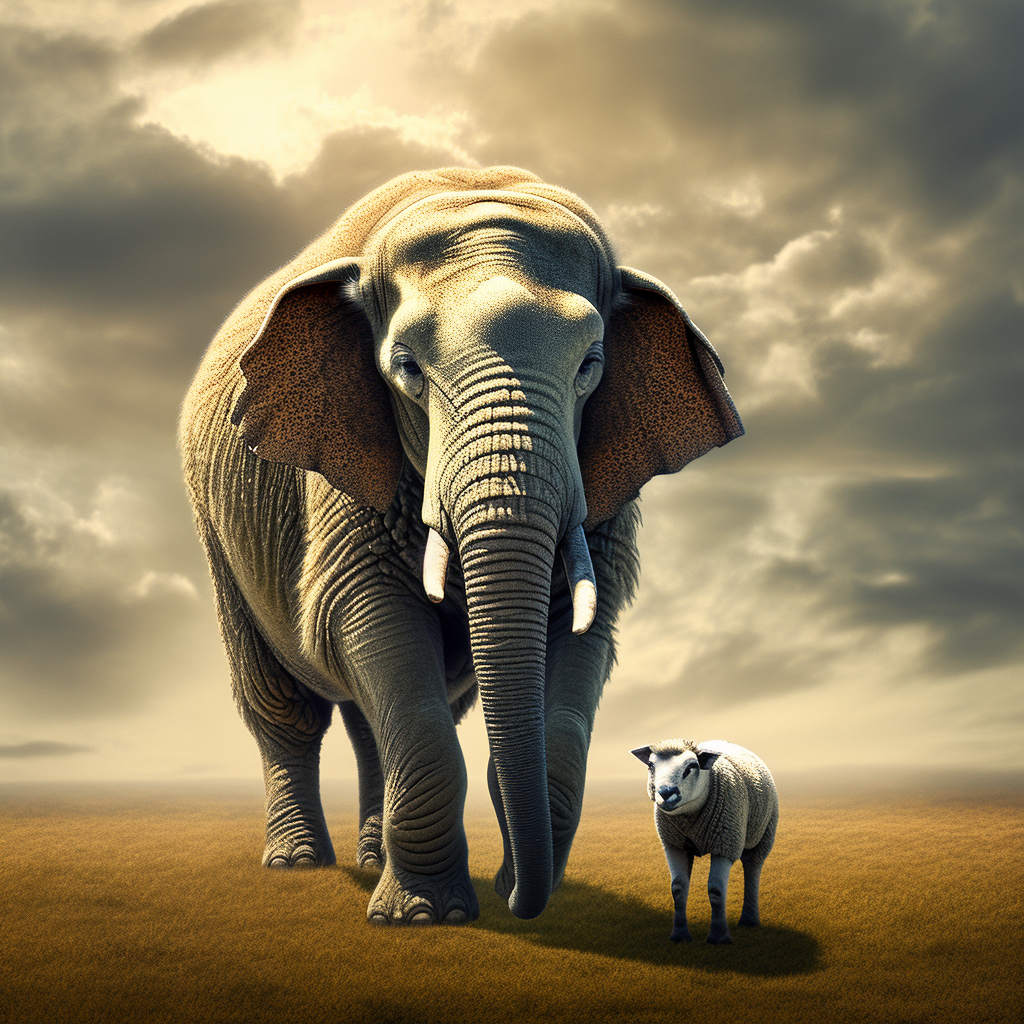

In [ ]:
prompt = "A sheep behind an elephant."
pipe(prompt).images[0]